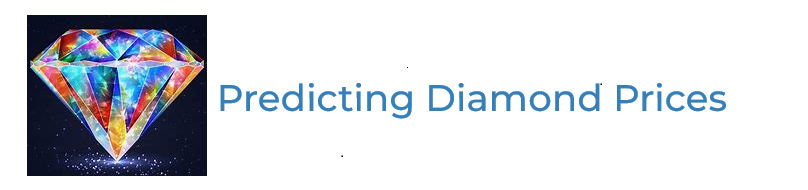

# 1_Introduction


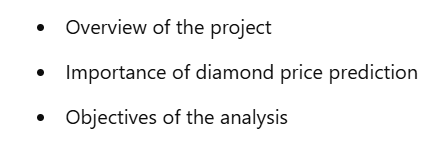

The goal of this report is to analyze the impact of various factors on diamond prices and develop a predictive model for accurate diamond pricing. Specifically, this study examines the influence of cut, color, and clarity, along with other size-related features like carat weight, depth, table, and dimensions. We have employed a variety of data preprocessing techniques, feature selection methods, and machine learning algorithms, including linear regression, XGBoost, and advanced optimization techniques, to identify the most important factors and achieve a robust predictive model.

# 2_About the data

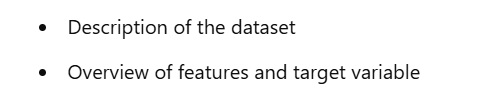

This classic dataset contains the prices and other attributes of almost 54,000 diamonds. It's a great dataset for beginners learning to work with data analysis and visualization.

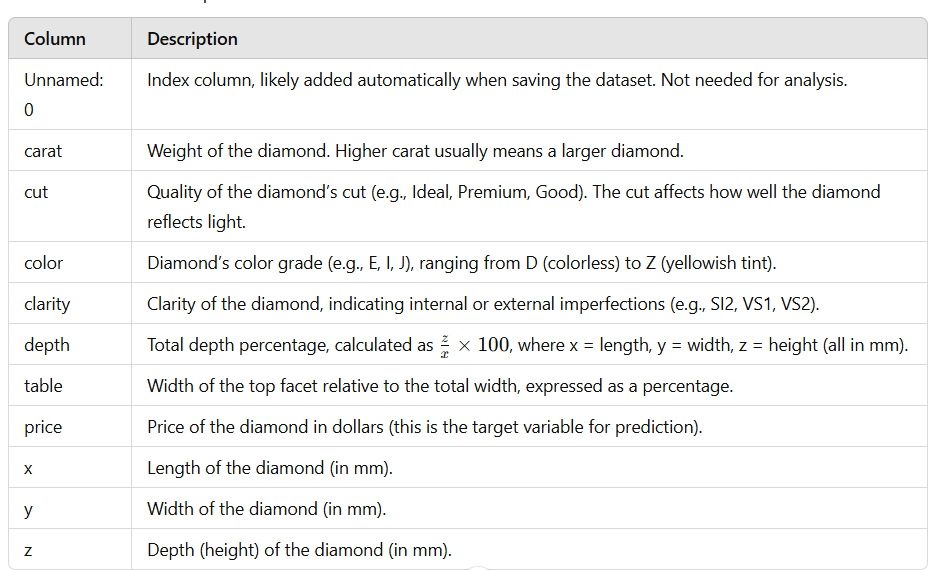

Additional notes:
* **Color**:Colorless diamonds (graded D, E, F) are considered more desirable and valuable compared to diamonds with a tint (graded G to Z).

Data Source: https://www.kaggle.com/code/nancyalaswad90/diamonds-prices-ideas

# 3_Load Packages and Dependencies

In [1]:
#Upgrade kagglehub version
#!pip install --upgrade --no-cache-dir kagglehub

In [2]:
#!pip install --upgrade kagglehub

In [3]:
!pip install category_encoders

In [4]:
# Show the version
#pip show kagglehub

In [5]:
import kagglehub
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings

path = kagglehub.dataset_download("nancyalaswad90/diamonds-prices")
print("Data source import complete.")

Data source import complete.


In [6]:
print(kagglehub.__version__)

0.3.11


In [7]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from numpy.linalg import eig

# 4_Load and Glimpse Data

In [8]:
data = pd.read_csv(path + '/Diamonds Prices2022.csv')
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [9]:
print(f'The dataset has {len(data)} observations.')

The dataset has 53943 observations.


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53943 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53943 non-null  int64  
 1   carat       53943 non-null  float64
 2   cut         53943 non-null  object 
 3   color       53943 non-null  object 
 4   clarity     53943 non-null  object 
 5   depth       53943 non-null  float64
 6   table       53943 non-null  float64
 7   price       53943 non-null  int64  
 8   x           53943 non-null  float64
 9   y           53943 non-null  float64
 10  z           53943 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


# 5_Data Cleaning

In [11]:
# Check for duplicates
data.duplicated().sum()

np.int64(0)

In [12]:
# Check for missing values
data.isnull().sum().any()

np.False_

In [13]:
data.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000,53943.000000
mean,26972.000000,0.797935,61.749322,57.457251,3932.734294,5.731158,5.734526,3.538730
std,15572.147122,0.473999,1.432626,2.234549,3989.338447,1.121730,1.142103,0.705679
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13486.500000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26972.000000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40457.500000,1.040000,62.500000,59.000000,5324.000000,6.540000,6.540000,4.040000
max,53943.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


<font size=5, color=indigo>💎**OBSERVATIONS**</font>

The physical dimensions x, y, and z exhibit minimum values of 0. Since it is impossible for a physical dimension to be 0, we should treat these as missing values and exclude them from the dataset

In [14]:
# For columns x , y, z, count all the rows that have 0 as a value
print(f"There are {(data['x'] == 0).sum()} rows with 0 as a value in the column x.")
print(f"There are {(data['y'] == 0).sum()} rows with 0 as a value in the column y.")
print(f"There are {(data['z'] == 0).sum()} rows with 0 as a value in the column z.")


There are 8 rows with 0 as a value in the column x.
There are 7 rows with 0 as a value in the column y.
There are 20 rows with 0 as a value in the column z.


In [15]:
# Drop all rows that have a 0 in columns x, y, and z
data = data[(data['x'] != 0) & (data['y'] != 0) & (data['z'] != 0)]
#len(data)

In [16]:
# Rename columns
data.rename(columns={'x' : 'length', 'y' : 'width', 'z' : 'height'}, inplace=True)

In [17]:
# Drop unneccessary columns
data.drop(columns=['Unnamed: 0'], inplace=True)

In [18]:
# Create a list with all numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_features)

['carat', 'depth', 'table', 'price', 'length', 'width', 'height']


In [19]:
# Create a list with categorical features
categorical_features =[col for col in data.columns if col not in numerical_features]
print(categorical_features)

['cut', 'color', 'clarity']


In [20]:
df = data.copy()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53923 entries, 0 to 53942
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53923 non-null  float64
 1   cut      53923 non-null  object 
 2   color    53923 non-null  object 
 3   clarity  53923 non-null  object 
 4   depth    53923 non-null  float64
 5   table    53923 non-null  float64
 6   price    53923 non-null  int64  
 7   length   53923 non-null  float64
 8   width    53923 non-null  float64
 9   height   53923 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


# 6_Exploratory Data Analysis (EDA)

## 6.1_Univariate Analysis

### 6.1.1_Numerical Feature Distributions

In [22]:
df[numerical_features].describe()

,carat,depth,table,price,length,width,height
count,53923.000000,53923.000000,53923.000000,53923.000000,53923.000000,53923.000000,53923.000000
mean,0.797693,61.749432,57.456902,3930.927879,5.731628,5.734888,3.540042
std,0.473783,1.432336,2.234123,3987.179153,1.119392,1.140094,0.702511
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5322.500000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [23]:
def describe_skew(skew):
    if skew < -1:
        print("Highly left-skewed distribution. If the selected model assumes normality, consider transforming this feature.")
    elif skew > 1:
        print("Highly right-skewed distribution. If the selected model assumes normality, consider transforming this feature.")
    elif -1 <= skew < -0.5:
        print("Moderately left-skewed distribution. If the selected model assumes normality, consider transforming this feature.")
    elif 0.5 < skew <= 1:
        print("Moderately right-skewed distribution. If the selected model assumes normality, consider transforming this feature.")
    elif -0.5 <= skew < 0:
        print("Slightly left-skewed distribution. If the selected model assumes normality, consider transforming this feature.")
    elif 0 < skew <= 0.5:
        print("Slightly right-skewed distribution. If the selected model assumes normality, consider transforming this feature.")
    elif skew == 0:
        print("Symmetric distribution.")
    else:
        print("Invalid skewness value.")

def describe_kurtosis(kurt):
    if kurt < 3:
        print("Light-tailed distribution: Fewer outliers present. Outliers can affect model performance if the model is not robust to outliers.")
    elif kurt > 3:
        print("Heavy-tailed distribution: Extreme number of outliers present. Outliers can significantly impact model performance if the model is not robust to outliers.")
    else:
        print("Moderate number of outliers present. Outliers can significantly impact model performance if the model is not robust to outliers.")

def describe_variation(data, var):
    (osm, osr), (slope, intercept, r) = stats.probplot(data[var])
    r_squared = round(r**2, 2)
    if r_squared == 1:
        p = f'Perfect fit: R_squared = {r_squared} -> The data perfectly fits the theoretical distribution.'
    elif 0.7 <= r_squared < 1:
        p = f'Strong fit: R_squared = {r_squared} -> The data closely follows the theoretical distribution but their are deviations due to outliers.'
    elif 0.4 <= r_squared < 0.7:
        p = f'Moderate fit: R_squared = {r_squared} -> The data has a moderate level of alignment with the theoretical distribution.'
    elif 0.2 <= r_squared < 0.4:
        p = f'Weak fit: R_squared = {r_squared} -> The data shows a weak alignment with the theoretical distribution, suggesting more pronounced deviations.'
    else:
        p = f'Very Weak fit: R_squared = {r_squared} -> The data significantly deviates from the theoretical distribution, indicating a very weak fit or no fit at all.'
    print(p)
    print('\n')

In [24]:
def plot_numerical_features(dframe, num_feats):
  for feature in num_feats:
          # Create a figure and 3 subplots (1 row, 3 columns)
          fig, axes = plt.subplots(1, 3, figsize=(12, 4))
          plt.subplots_adjust(wspace=0.5)

          # Plot 1: Histogram with kde
          sns.histplot(data=dframe, x=feature, kde=True, ax=axes[0], color='lightseagreen')
          axes[0].set_title(f'Histogram: {feature}')
          axes[0].set_xlabel('')
          axes[0].set_ylabel('')

          # Plot 2: Violin Plot
          sns.violinplot(data=dframe, y=feature, ax=axes[1])
          axes[1].set_title(f'Violin Plot: {feature}')
          axes[1].set_xlabel('')
          axes[1].set_ylabel('')

          # Plot 3: Q-Q Plot
          stats.probplot(dframe[feature], plot=axes[2])
          axes[2].set_title(f'Q-Q Plot: {feature}')
          axes[2].set_xlabel('')
          axes[2].set_ylabel('')
          # Display the plots
          plt.show()

          # Print result of skew and kurtosis analysis
          s = round(df[feature].skew(), 2)
          k = round(df[feature].kurt(), 2)   # Fisher's kurtosis

          describe_skew(s)
          describe_kurtosis(k)
          describe_variation(dframe, feature)

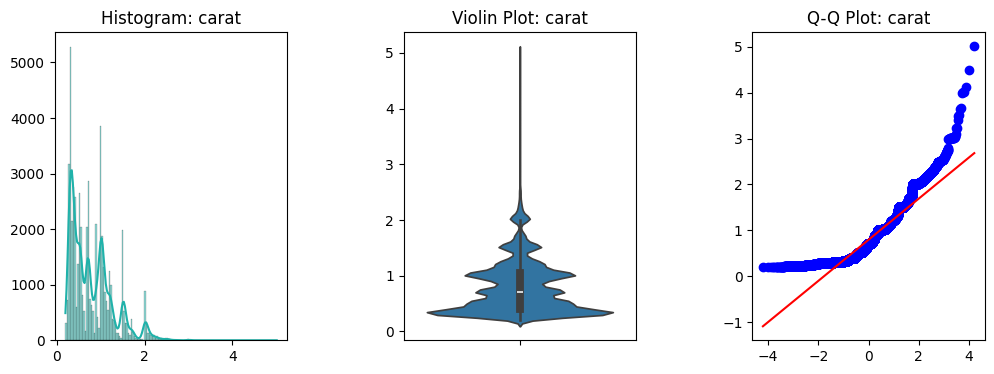

Highly right-skewed distribution. If the selected model assumes normality, consider transforming this feature.
Light-tailed distribution: Fewer outliers present. Outliers can affect model performance if the model is not robust to outliers.
Strong fit: R_squared = 0.89 -> The data closely follows the theoretical distribution but their are deviations due to outliers.




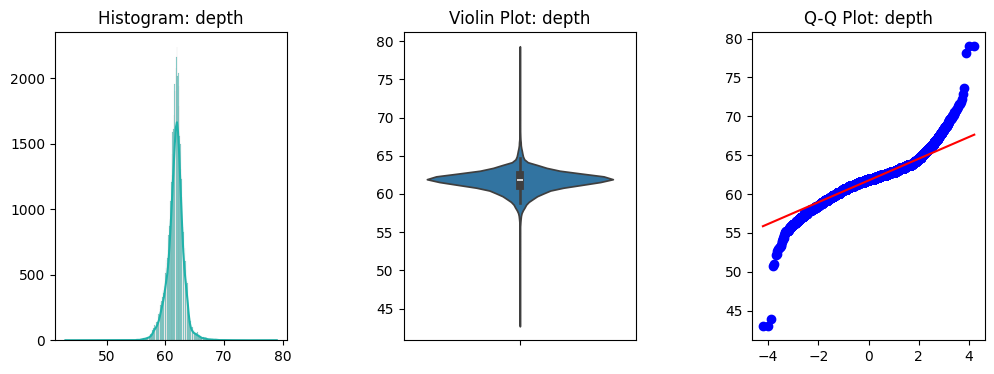

Slightly left-skewed distribution. If the selected model assumes normality, consider transforming this feature.
Heavy-tailed distribution: Extreme number of outliers present. Outliers can significantly impact model performance if the model is not robust to outliers.
Strong fit: R_squared = 0.95 -> The data closely follows the theoretical distribution but their are deviations due to outliers.




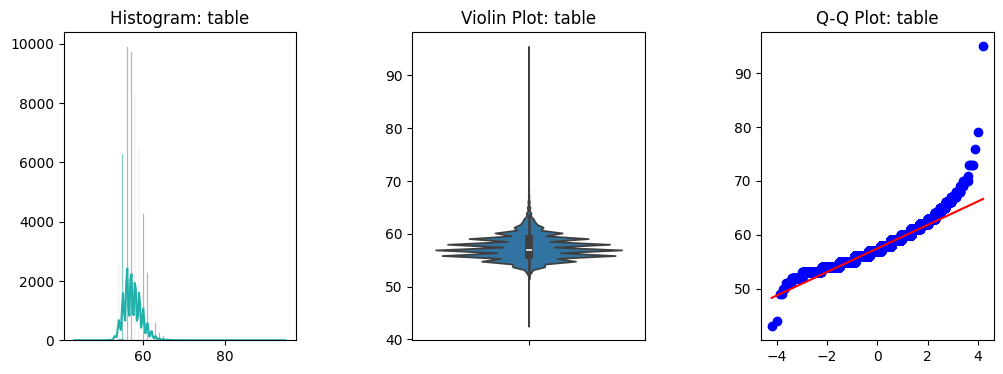

Moderately right-skewed distribution. If the selected model assumes normality, consider transforming this feature.
Light-tailed distribution: Fewer outliers present. Outliers can affect model performance if the model is not robust to outliers.
Strong fit: R_squared = 0.95 -> The data closely follows the theoretical distribution but their are deviations due to outliers.




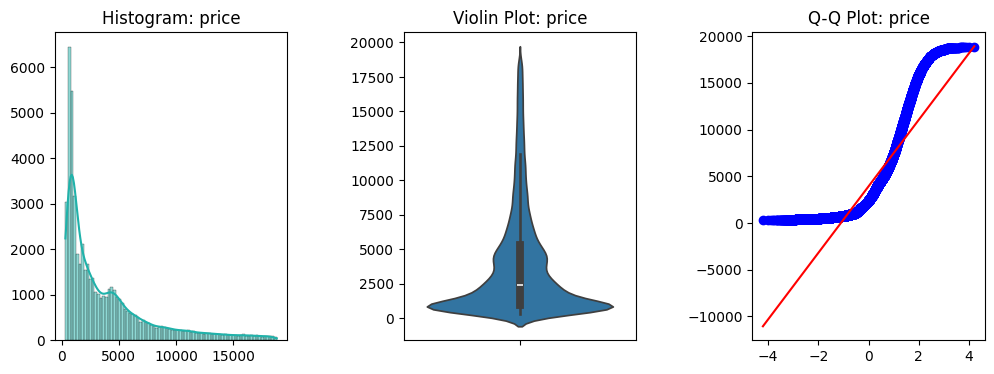

Highly right-skewed distribution. If the selected model assumes normality, consider transforming this feature.
Light-tailed distribution: Fewer outliers present. Outliers can affect model performance if the model is not robust to outliers.
Strong fit: R_squared = 0.8 -> The data closely follows the theoretical distribution but their are deviations due to outliers.




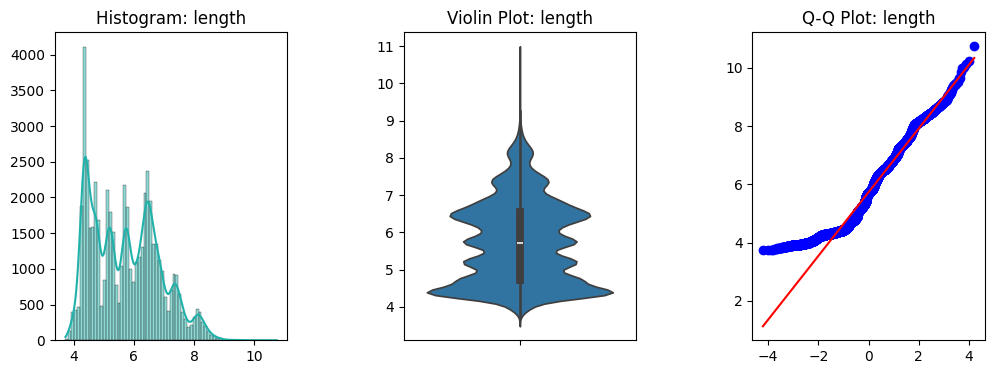

Slightly right-skewed distribution. If the selected model assumes normality, consider transforming this feature.
Light-tailed distribution: Fewer outliers present. Outliers can affect model performance if the model is not robust to outliers.
Strong fit: R_squared = 0.96 -> The data closely follows the theoretical distribution but their are deviations due to outliers.




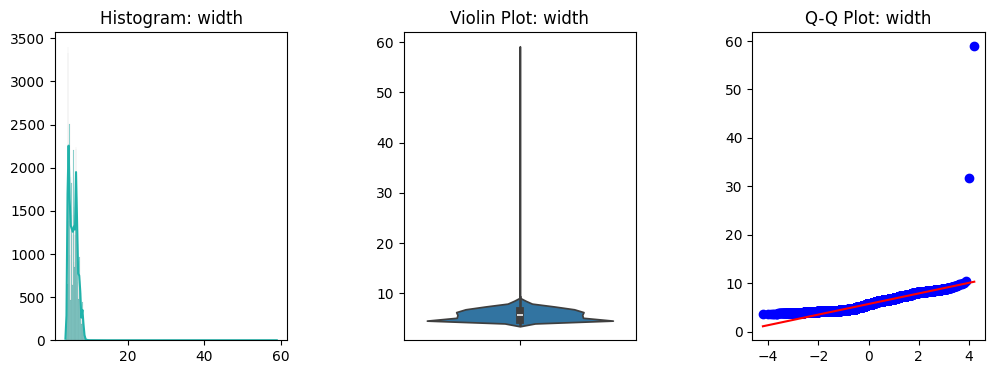

Highly right-skewed distribution. If the selected model assumes normality, consider transforming this feature.
Heavy-tailed distribution: Extreme number of outliers present. Outliers can significantly impact model performance if the model is not robust to outliers.
Strong fit: R_squared = 0.92 -> The data closely follows the theoretical distribution but their are deviations due to outliers.




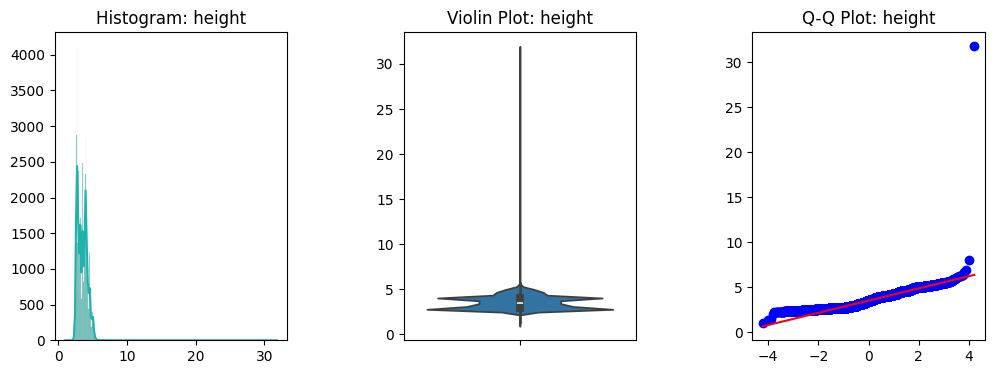

Highly right-skewed distribution. If the selected model assumes normality, consider transforming this feature.
Heavy-tailed distribution: Extreme number of outliers present. Outliers can significantly impact model performance if the model is not robust to outliers.
Strong fit: R_squared = 0.93 -> The data closely follows the theoretical distribution but their are deviations due to outliers.




In [25]:
plot_numerical_features(df, numerical_features)

### 6.1.2_Outlier Analysis

In [26]:
# for each numerical feature determine the percentage of outliers out of all data points
for feature in numerical_features:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    percentage_outliers = (len(outliers) / len(df)) * 100
    print(f"Percentage of outliers in {feature}: {percentage_outliers:.2f}%")

Percentage of outliers in carat: 3.49%
Percentage of outliers in depth: 4.72%
Percentage of outliers in table: 1.12%
Percentage of outliers in price: 6.55%
Percentage of outliers in length: 0.04%
Percentage of outliers in width: 0.04%
Percentage of outliers in height: 0.05%


💡<font color=indigo>XGBoost (and tree-based models in general) is much more robust to outliers than linear regression.</font>

### 6.1.3_Categorical Features Distributions

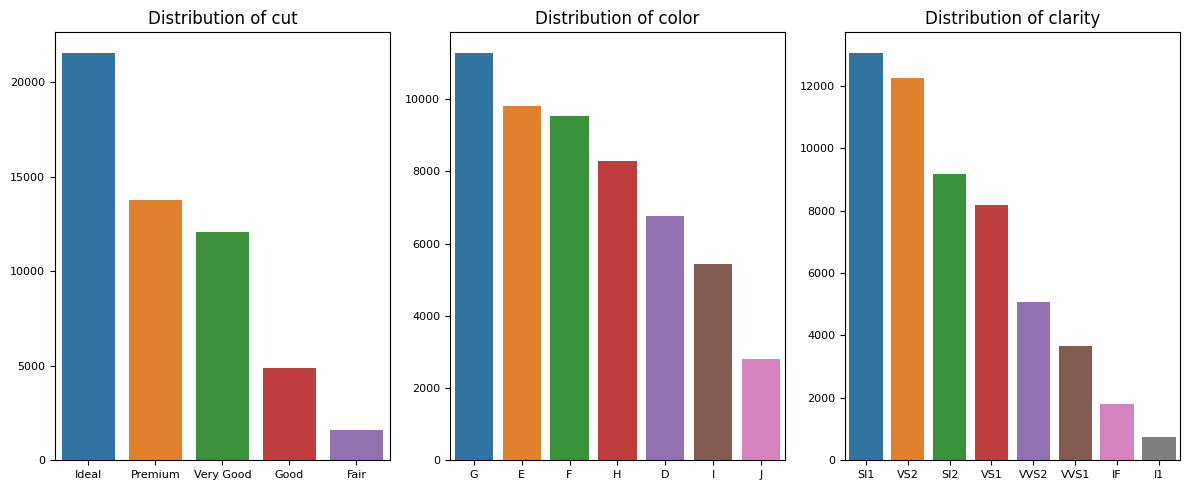

In [27]:
# Set number of plots per row
plts_per_row = 3
nr_features = len(categorical_features)
rows = (nr_features // plts_per_row) + (nr_features % plts_per_row > 0)

fig, axes = plt.subplots(rows, plts_per_row, figsize=(12, 5 * rows))
axes = axes.flatten()  # Flatten in case of multiple rows

for i, feature in enumerate(categorical_features):
  feature_counts = df[feature].value_counts().reset_index()
  feature_counts.columns = [feature, 'count']

  # Plot
  sns.barplot(x=feature, y='count', data=feature_counts, hue=feature_counts[feature], ax=axes[i])
  axes[i].set_title(f'Distribution of {feature}')
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')

  # Adjust the xlabel font size
  axes[i].tick_params(axis='x', labelsize=8)
  axes[i].tick_params(axis='y', labelsize=8)
# Hide unused subplots if the number of features is odd
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 6.2_Bivariate Analysis

#### 6.2.1_Distribution of Price by Cut

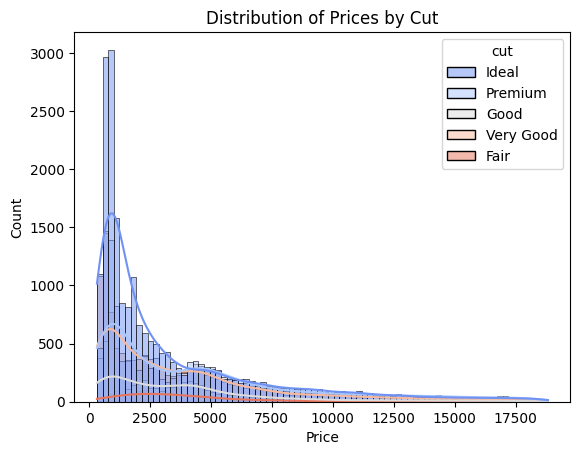

In [28]:
sns.histplot(data=df, x='price', hue='cut', kde=True, palette='coolwarm')
plt.title('Distribution of Prices by Cut')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

<font color=indigo>💎**OBSERVATIONS**</font>

* **Majority of Diamonds Priced Below 5,000**: Most diamonds are priced below 5,000, with a significant concentration of diamonds priced between 0 and 2,500.

* **Cut Quality Distribution**: The Ideal cut diamonds have the highest count, followed by Premium, Very Good, Good, and Fair cuts.

* **Right-Skewed Distribution**: The distribution is right-skewed, indicating that higher-priced diamonds are less common.

* **Impact of Cut on Price**: Different cut qualities show varying price distributions, with Ideal and Premium cuts generally having higher counts at higher price points compared to other cuts.

In [29]:
print("Descriptive statistics: price for each cut")
df.groupby('cut')['price'].describe().reset_index()

Descriptive statistics: price for each cut


,cut,count,mean,std,min,25%,50%,75%,max
0,Fair,1609.0,4357.500932,3561.136245,337.0,2050.00,3282.0,5198.00,18574.0
1,Good,4902.0,3926.403509,3676.772435,327.0,1144.25,3050.5,5028.00,18707.0
2,Ideal,21548.0,3456.941201,3808.093737,326.0,878.00,1809.5,4678.00,18806.0
3,Premium,13782.0,4579.419896,4343.646613,326.0,1046.00,3181.0,6290.00,18823.0
4,Very Good,12082.0,3981.562738,3935.863847,336.0,912.00,2648.0,5372.75,18818.0


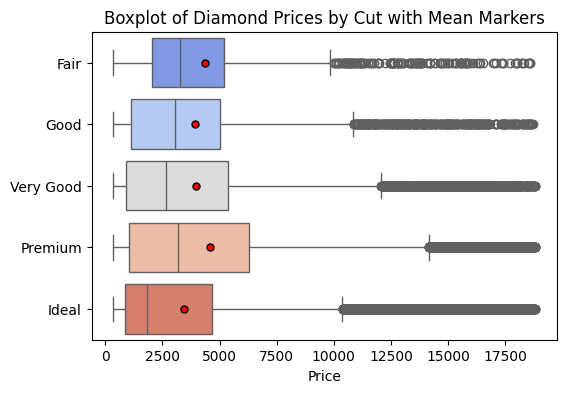

In [30]:
plt.figure(figsize=(6, 4))
cut_order= ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
sns.boxplot(x='price', y='cut', data=df, showmeans=True, order=cut_order, palette='coolwarm',
            meanprops={"marker":"o","markerfacecolor":"red", "markeredgecolor":"black","markersize":"5"}) #lower grade -> highest grade
plt.ylabel("")
plt.xlabel("Price")
plt.title('Boxplot of Diamond Prices by Cut with Mean Markers')
plt.show()

<font color=indigo>💎**OBSERVATIONS**</font>
* **Variation**: High standard deviations across all cuts indicate significant price variability within each cut category.

* **Median vs. Mean**: For all cuts, the median price is lower than the mean, indicating a right-skewed distribution where some diamonds are significantly more expensive.


### 6.2.2_Distribution of Price by Color

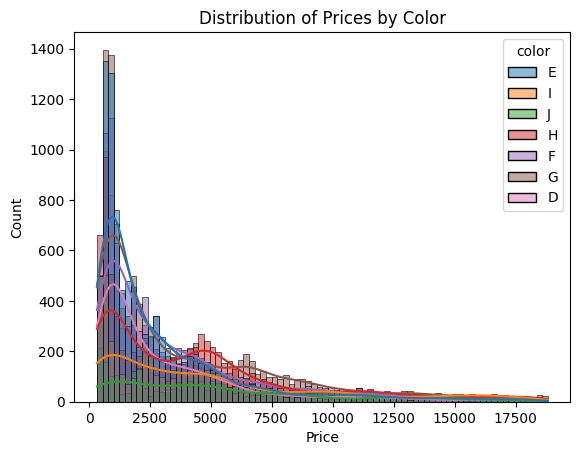

In [31]:
sns.histplot(data=df, x='price', hue='color', kde=True)
plt.title('Distribution of Prices by Color')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

<font color=indigo>💎**OBSERVATIONS**</font>

* **Majority of Diamonds Priced Below 5,000**: Most diamonds are priced below 5,000, with a significant concentration of diamonds priced between 0 and 2,500.

* **Color Grade Distribution**: The distribution shows that diamonds with different color grades have varying frequencies within the price range.

* Diamonds with color grades D and E **(higher quality)** are less frequent in the higher price range.

* Diamonds with color grades I and J **(lower quality)** are more frequent in the lower price range.

* **Right-Skewed Distribution**: The distribution is right-skewed, indicating that higher-priced diamonds are less common.

* **Impact of Color on Price**: The plot suggests that the color grade of diamonds has an influence on their price distribution, with lower-quality color grades being more prevalent at lower prices.

In [32]:
print("Descriptive statistics: price for each color")
df.groupby('color')['price'].describe().reset_index()

Descriptive statistics: price for each color


,color,count,mean,std,min,25%,50%,75%,max
0,D,6774.0,3168.106436,3353.391411,357.0,911.0,1836.5,4212.5,18693.0
1,E,9799.0,3076.687111,3343.820487,326.0,882.5,1739.0,4001.5,18731.0
2,F,9539.0,3724.978614,3785.508665,342.0,982.0,2344.0,4867.5,18791.0
3,G,11284.0,3996.876551,4049.165898,354.0,931.0,2240.0,6048.0,18818.0
4,H,8298.0,4480.942155,4208.831366,337.0,984.0,3453.5,5975.0,18803.0
5,I,5421.0,5089.973990,4720.748071,334.0,1120.0,3730.0,7186.0,18823.0
6,J,2808.0,5323.818020,4438.187251,335.0,1860.5,4234.0,7695.0,18710.0


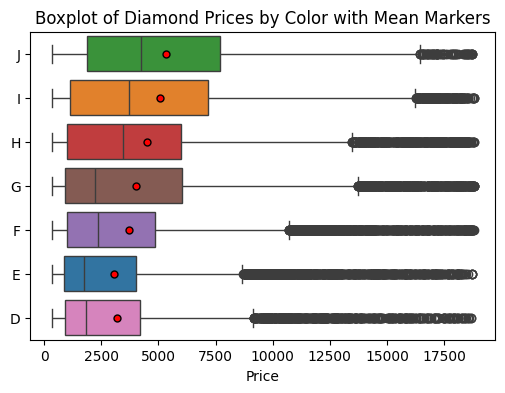

In [33]:
plt.figure(figsize=(6,4))
color_order =['J', 'I', 'H', 'G', 'F', 'E','D'] # colorful(dark) -> colorless(light)
sns.boxplot(x='price', y='color', data=df,showmeans=True,order=color_order, hue='color',
            meanprops={"marker":"o","markerfacecolor":"red", "markeredgecolor":"black","markersize":"5"})
plt.title('Boxplot of Diamond Prices by Color with Mean Markers')
plt.ylabel("")
plt.xlabel("Price")
plt.show()

<font color=indigo>💎**OBSERVATIONS**</font>
* As the color grade moves from D to J, the mean price of the diamonds increases, indicating that diamonds with slightly more color (near colorless) can still be quite valuable.
* Each color grade shows substantial price variability.

### 6.2.3_Distribution of Price by Clarity


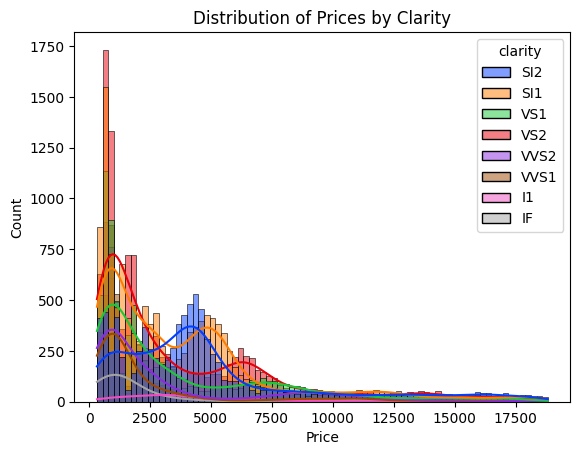

In [34]:
sns.histplot(data=df, x='price', hue='clarity', palette='bright', kde=True)
plt.title('Distribution of Prices by Clarity')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

<font color=indigo>💎**OBSERVATIONS**</font>
* **Price Distribution**: Most diamonds are priced below 5000, with a higher concentration of diamonds in the lower price range.

* **Variation by Clarity**: The distribution of prices varies by clarity grade. Some clarity grades have more diamonds in higher price ranges.

In [35]:
print("Descriptive statistics: price for each clarity level")
df.groupby('clarity')['price'].describe().reset_index()

Descriptive statistics: price for each clarity level


,clarity,count,mean,std,min,25%,50%,75%,max
0,I1,738.0,3926.189702,2811.615917,345.0,2071.00,3346.0,5167.75,18531.0
1,IF,1790.0,2864.839106,3920.248499,369.0,895.00,1080.0,2388.50,18806.0
2,SI1,13065.0,3993.923077,3796.430128,326.0,1089.00,2822.0,5249.00,18818.0
3,SI2,9185.0,5060.440174,4256.944654,326.0,2264.00,4072.0,5775.00,18804.0
4,VS1,8170.0,3839.144308,4011.894939,327.0,876.00,2005.0,6021.00,18795.0
5,VS2,12255.0,3922.771685,4039.914100,334.0,900.00,2052.0,6022.50,18823.0
6,VVS1,3654.0,2519.512315,3328.175459,336.0,816.00,1092.5,2376.00,18777.0
7,VVS2,5066.0,3283.737071,3821.647537,336.0,794.25,1311.0,3638.25,18768.0


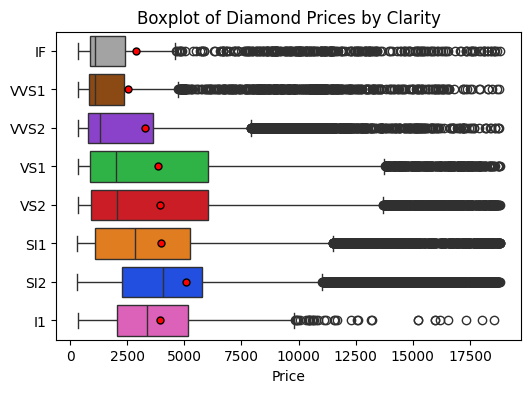

In [36]:
plt.figure(figsize=(6,4))
clarity_order = ['IF','VVS1','VVS2','VS1', 'VS2', 'SI1', 'SI2', 'I1'  ] # most -> least clear
sns.boxplot(x='price', y='clarity', data=df, showmeans=True,order=clarity_order, hue='clarity', palette='bright',
            meanprops={"marker":"o","markerfacecolor":"red", "markeredgecolor":"black","markersize":"5"} )
plt.title('Boxplot of Diamond Prices by Clarity')
plt.ylabel("")
plt.xlabel("Price")
plt.show()

<font color=indigo>💎**OBSERVATIONS**</font>
* Higher clarity diamonds, like IF, VVS1, and VVS2, tend to have lower mean prices compared to lower clarity diamonds like SI2.
* Standard deviations indicate significant price variability within each clarity category, with some outliers reaching high prices.

### 6.2.4 Chi-square Tests: Determine the strength and significance of associations between categorical variable pairs


In [37]:
from scipy.stats import chi2_contingency

# Chi-square test between cut and color
contingency_table_cut_color = pd.crosstab(df['cut'], df['color'])
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table_cut_color)
print(f"Chi-square test between cut and color: Chi2 Stat={chi2_stat:.2f}, P-value={p_val:.4f}")
if p_val < 0.05 :
  print("Cut and color are associated.")
else:
  print("Cut and color are not associated.")

# Chi-square test between cut and clarity
contingency_table_cut_clarity = pd.crosstab(df['cut'], df['clarity'])
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table_cut_clarity)
print(f"Chi-square test between cut and clarity: Chi2 Stat={chi2_stat:.2f}, P-value={p_val:.4f}")
if p_val < 0.05:
  print("Cut and clarity are associated.")
else:
  print("Cut and clarity are not associated.")

# Chi-square test between color and clarity
contingency_table_color_clarity = pd.crosstab(df['color'], df['clarity'])
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table_color_clarity)
print(f"Chi-square test between color and clarity: Chi2 Stat={chi2_stat}, P-value={p_val}")
if p_val < 0.05:
  print("Color and clarity are associated.")
else:
  print("Color and clarity are not associated.")

Chi-square test between cut and color: Chi2 Stat=309.66, P-value=0.0000
Cut and color are associated.
Chi-square test between cut and clarity: Chi2 Stat=4396.08, P-value=0.0000
Cut and clarity are associated.
Chi-square test between color and clarity: Chi2 Stat=2048.854908376933, P-value=0.0
Color and clarity are associated.


## 6.3_Multivariate Analysis

### 6.3.1_Correlation Analysis

Influence of Numerical Variables on the Dependent Variable

**Anything below or equal to 0.03 can be ignored very close to 0.**

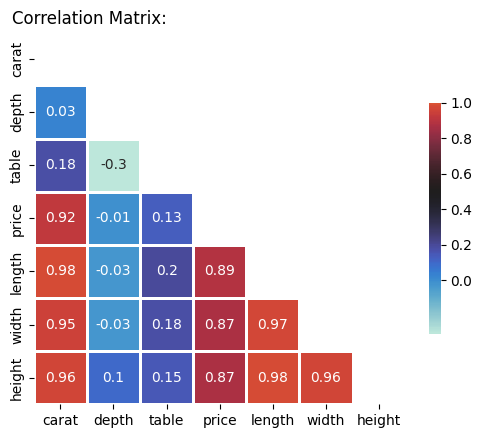

In [38]:
corr_matrix = df[numerical_features].corr().round(2)
# Generate a mask to the upper triangle of the matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(6, 6))
# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr_matrix, mask=mask,  vmax=1, center=0.5,
                 square=True, linewidths=0.8,
                 cbar_kws={"shrink": .5, 'ticks':[0, 0.2, 0.4, 0.6, 0.8, 1]}, annot=True)
plt.title("Correlation Matrix:", x=0.15)
plt.show()

<font color=indigo>💎**OBSERVATIONS**</font>

- **Correlation between predictors and target**:Variables such as `carat`, `length`, `width`, and `height` are significant predictors of diamond price, whereas `depth` and `table` have a minimal impact. Predictors that show high correlation with the target variable typically contribute to a model that fits the data effectively, thereby facilitating feature selection for predictive modeling.




- **Correlations between predictors**:The variables `carat`, `length`, `width`, and `height` are highly correlated with each other. This multicollinearity makes it challenging to isolate the individual impact of each dimension on the price, which can affect the stability and interpretability of regression models.

*A pair plot visually represents the relationships between pairs of variables, reflecting what is quantified in the correlation matrix.*

**The diagonal in a pair plot typically shows the distribution of each individual variable. For continuous variables, this is often represented by a histogram or a kernel density estimate (KDE). So, in the diagonal of a pair plot, you're seeing the distribution of the variable (e.g., the distribution of carat values), not a scatter plot or a correlation.**

<font color = 'indigo'>Correlation of 1 indeed means that R² is also 1, indicating a perfect linear relationship with no deviation from the line of best fit.</font>

In [39]:
print(numerical_features)

['carat', 'depth', 'table', 'price', 'length', 'width', 'height']


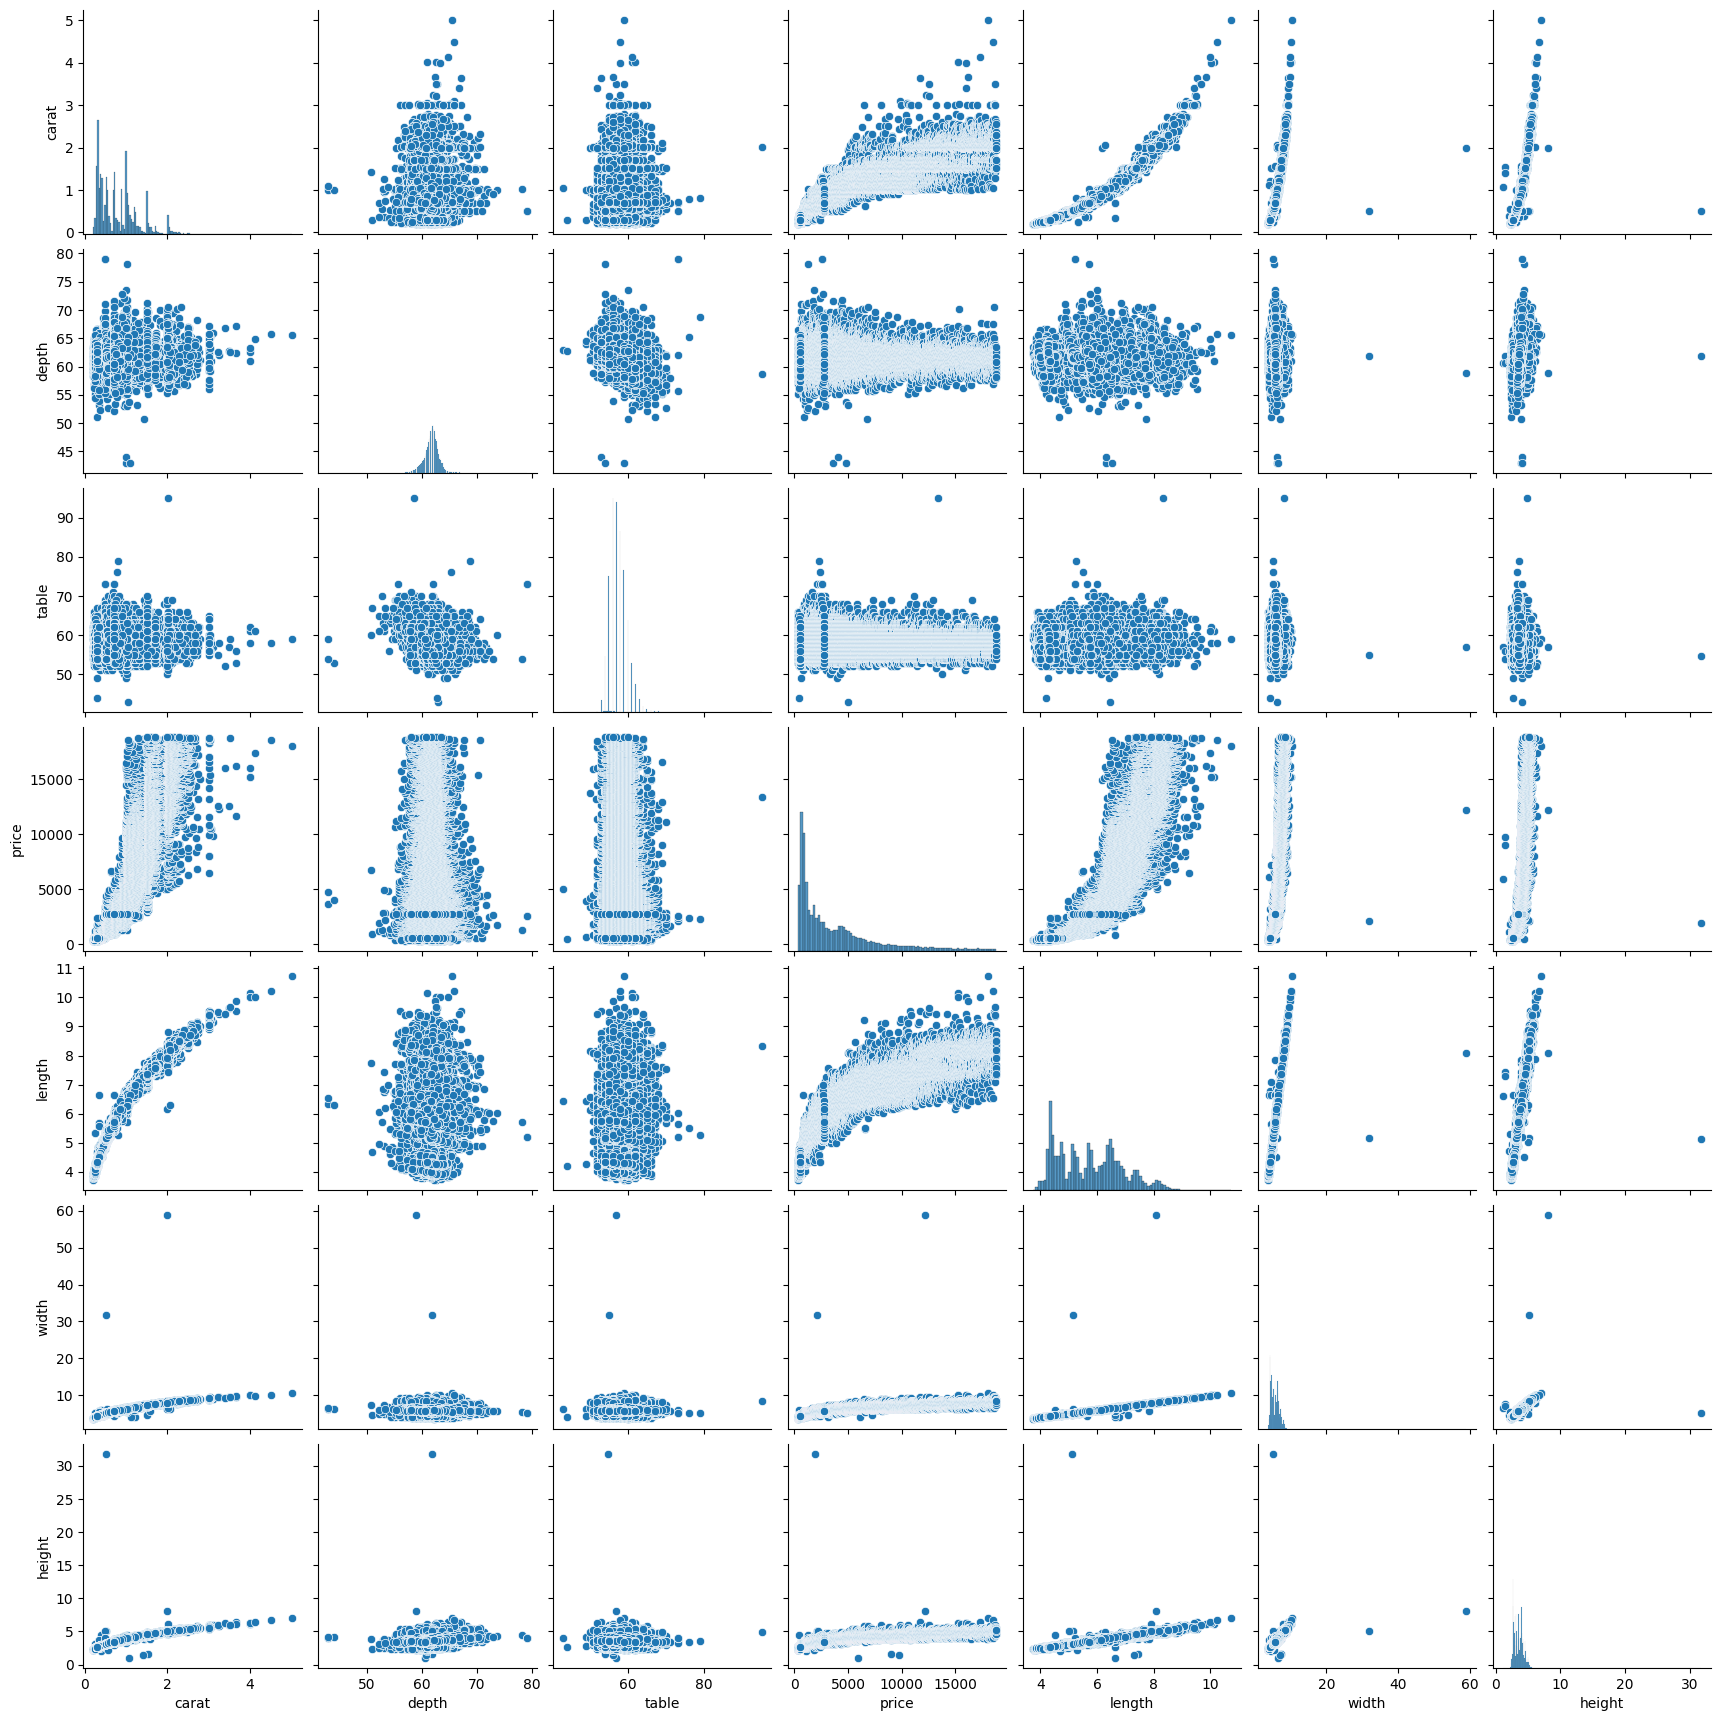

In [40]:
# Pair plot of selected continuous variables
sns.pairplot(df[numerical_features])
plt.show()

### 6.3.2_Average Price by Cut and Clarity



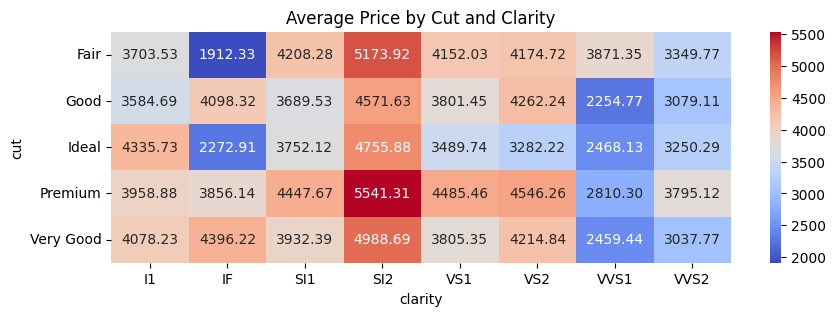

In [41]:
pivot_table = pd.pivot_table(df, values='price', index='cut', columns='clarity', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(10, 3))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Average Price by Cut and Clarity')
plt.show()

### 6.3.3_Analyzing the Effect of Categorical Features on the Dependent Variable

Type II multi-way ANOVA

* **multi_way** : ANOVA is multi-way (in this case, a three-way ANOVA): 3 factors: cut, color, clarity: Do multiple factors each explain differences in the dependent variable?"
* **Type II** :tests main effects after accounting for other main effects, but not interactions. This is typically appropriate when you have balanced data (or near-balanced data) and you're interested in the marginal effects of each factor.
* **Type II (Marginal SS)** does not depend on order but tests each factor after accounting for other factors, assuming no interaction.

In [42]:
df_anova = df[categorical_features + ['price']]

# Convert categorical variables to categorical dtype
df_anova['cut'] = df_anova['cut'].astype('category')
df_anova['color'] = df_anova['color'].astype('category')
df_anova['clarity'] = df_anova['clarity'].astype('category')

# Perform ANOVA
model = smf.ols('price ~ cut + color + clarity', data=df_anova).fit()
anova_results = sm.stats.anova_lm(model, typ=2)  # Use typ=2 for Type II ANOVA

# Display results
print(anova_results)

                sum_sq       df           F         PR(>F)
cut       5.524991e+09      4.0   92.974020   6.163694e-79
color     2.654385e+10      6.0  297.784935   0.000000e+00
clarity   1.998506e+10      7.0  192.175197  9.906918e-283
Residual  8.008276e+11  53905.0         NaN            NaN


In [43]:
p_value_cut = anova_results.loc['cut', 'PR(>F)']
if p_value_cut < 0.05:
    print("Cut has a significant impact on diamond price.")
else:
    print("Cut does not have a significant impact on diamond price.")

p_value_color = anova_results.loc['color', 'PR(>F)']
if p_value_color < 0.05:
    print("Color has a significant impact on diamond price.")
else:
    print("Color does not have a significant impact on diamond price.")

p_value_clarity = anova_results.loc['clarity', 'PR(>F)']
if p_value_clarity < 0.05:
    print("Clarity has a significant impact on diamond price.")
else:
    print("Clarity does not have a significant impact on diamond price.")

Cut has a significant impact on diamond price.
Color has a significant impact on diamond price.
Clarity has a significant impact on diamond price.


<font color=indigo>💎**OBSERVATIONS**</font>

All three factors — `cut`, `color`, `clarity` — have very strong and statistically significant effect on price; we should **keep the predictors**.

* `color` has the largest effect (highest sum_sq and F).
* `clarity` is also very impactful.
* `cut` still matters, but less than the others.

# 7_Data Preprocessing

✔️ **Splitting first** - Prevents data leakage.

✔️ **Log transformations next** - Handles skewness before encoding and scaling.

✔️ **Encoding categorical variables** - Converts categories into numerical format before scaling.

✔️ **Standardizing last** - Ensures all numerical features (including transformed ones) are on the same scale.


## 7.1_Splitting Data into Training and Test Sets

In [44]:
X = df.drop(columns=['price'])
y = df['price']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Define num_features
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [47]:
X_train.describe()

,carat,depth,table,length,width,height
count,43138.000000,43138.000000,43138.000000,43138.000000,43138.000000,43138.000000
mean,0.797218,61.746231,57.453579,5.730383,5.733320,3.539118
std,0.474043,1.423539,2.227121,1.119947,1.140877,0.705369
min,0.200000,43.000000,43.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.037500
max,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000


## 7.2_Data Transformation

In [48]:
X_train_p = X_train.copy()
X_test_p = X_test.copy()

### 7.2.1_Apply Log Transformations to Skewed Numerical Features





*Apply log transformations before scaling.*

In [49]:
# Log transform Features and Target
X_train_p[num_features] = np.log1p(X_train[num_features])
X_test_p[num_features] = np.log1p(X_test[num_features])

#plot_numerical_features(X_train_p, num_features)

### 7.2.2_Apply Log Transformations to Skewed Target Variable





In [50]:
# Log-transforming the target variables
y_train_log_series = np.log1p(y_train)
y_test_log_series = np.log1p(y_test)

y_train_log = pd.DataFrame(y_train_log_series, columns=['price']).reset_index(drop=True)
y_test_log = pd.DataFrame(y_test_log_series, columns=['price']).reset_index(drop=True)


## 7.3_Encode Categorical Features

### 7.3.1_Ordinal Encoding

*Apply ordinal encoding to features with inherent order.*

In [51]:
def encode_feature(encoder, train_data, test_data, column_name):
    train_data[column_name] = encoder.fit_transform(train_data[[column_name]])
    test_data[column_name] = encoder.transform(test_data[[column_name]])
    return train_data, test_data

In [52]:
# Encoders with specific order
oec1 = OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']])
oec2 = OrdinalEncoder(categories=[['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])

# Apply encoding
X_train_p, X_test_p = encode_feature(oec1, X_train_p, X_test_p, 'cut')
X_train_p, X_test_p = encode_feature(oec2, X_train_p, X_test_p, 'clarity')

### 7.3.2_Target Encoding

In [53]:
X_train_p['color'].nunique()

7

*Apply target encoding to categorical features without inherent order.*

* Target encoding directly shows how each color relates to the target variable (price), by computing the mean price for each color. It can capture complex patterns that ordinal or one-hot encoding might miss.
* One hot encoding could potentially lead to curse of dimensionality if dimensions are more than 15.

In [54]:
target_encoder = ce.TargetEncoder(cols=['color'])

X_train_p['color'] = target_encoder.fit_transform(X_train['color'], y_train)
X_test_p['color'] = target_encoder.transform(X_test['color'])

With these encodings in place, our categorical variables are now transformed into numerical values that your machine learning model can process effectively.

In [55]:
X_train_p.head()

,carat,cut,color,clarity,depth,table,length,width,height
24965,1.105257,3.0,4464.658746,2.0,4.158883,4.110874,2.180417,2.173615,1.780024
13617,0.693147,3.0,4464.658746,3.0,4.100989,4.127134,2.016235,2.009555,1.578979
24401,0.722706,2.0,3074.037886,7.0,4.149464,4.025352,2.014903,2.020222,1.623341
1826,0.542324,2.0,3714.552566,4.0,4.144721,4.094345,1.900614,1.908060,1.515127
32771,0.292670,4.0,3180.053638,2.0,4.154185,4.043051,1.701105,1.695616,1.335001


## 7.4_Standardize Features

In [56]:
scaler = StandardScaler()

# Fit and transform the entire DataFrame
X_train_p1_arr = scaler.fit_transform(X_train_p)
X_test_p1_arr = scaler.transform(X_test_p)

# Convert the numpy arrays back to DataFrame for easier handling
X_train_p1 = pd.DataFrame(X_train_p1_arr, columns=X_train_p.columns)
X_test_p1 = pd.DataFrame(X_test_p1_arr, columns=X_test_p.columns)

In [57]:
X_train_p1.head()

,carat,cut,color,clarity,depth,table,length,width,height
0,2.247413,0.082829,0.760456,-0.642391,0.880087,1.152004,1.746258,1.710696,1.845448
1,0.564517,0.082829,0.760456,-0.035243,-1.662019,1.584073,0.748709,0.708724,0.514813
2,0.685224,-0.815833,-1.212784,2.393352,0.466492,-1.120462,0.740613,0.773870,0.808427
3,-0.051385,-0.815833,-0.303917,0.571906,0.258225,0.712793,0.046207,0.088853,0.092208
4,-1.070877,0.981491,-1.062351,-0.642391,0.673777,-0.650155,-1.165983,-1.208625,-1.099970


# 8_Model Building & Evaluation

In [58]:
# Create a new empty dataframe
model_comparison_df = pd.DataFrame(columns=['Model', 'RMSE(Training Set)', 'RMSE(Test Set)', 'R_squared Score'])

In [59]:
def evaluate_model(model_name, model, X_train_m, X_test_m, y_train_m, y_test_m):
    # Make predictions in Log scale (y_train is log-transformed)
    y_pred_log_train = model.predict(X_train_m)
    y_pred_log_test = model.predict(X_test_m)

    # Convert predictions back to original scale
    y_pred_train = np.expm1(y_pred_log_train)
    y_pred_test = np.expm1(y_pred_log_test)

    # Evaluate the baseline model
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mean_price = y_test.mean()
    rmse_mean_pct = (rmse_test / mean_price) * 100
    r2 = r2_score(y_test, y_pred_test)


    # Append to model_comparison_df using pd.concat
    data = {'Model': model_name,
            'RMSE(Training Set)': round(rmse_train, 2),
            'RMSE(Test Set)': round(rmse_test, 2),
            'RMSE as pct of Mean Price': round(rmse_mean_pct, 2),
            'R_squared Score': round(r2, 2)}

    global model_comparison_df  # Ensure the DataFrame is accessible within the function
    model_comparison_df = pd.concat([model_comparison_df, pd.DataFrame([data])], ignore_index=True)


## 8.1_Baseline Model : Linear Regression

In [60]:
X_train_lr = X_train_p1.copy()
y_train_lr = y_train_log.copy()

X_test_lr = X_test_p1.copy()
y_test_lr = y_test_log.copy()

<font color=firebrick>*Root Mean Square Error (RMSE) measures the average magnitude of the errors between predicted values and actual target values in a regression model. It quantifies how far the predictions are from the actual values. RMSE is not directly related to the mean of the target values, but it provides an insight into the model's accuracy: the lower the RMSE, the closer the predicted values are to the actual values, indicating better model performance*.</font>

Train and evaluate a baseline Linear Regression model to set the benchmark.

In [61]:
# Build a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

evaluate_model('Baseline Model: Linear Regression', lr_model, X_train_lr, X_test_lr, y_train_lr, y_test_lr)
model_comparison_df

,Model,RMSE(Training Set),RMSE(Test Set),R_squared Score,RMSE as pct of Mean Price
0,Baseline Model: Linear Regression,1082.41,1003.27,0.94,25.47


<font color=indigo>💎**OBSERVATIONS**</font>

The test RMSE is very close to the training RMSE, which indicates that the **model is not overfitting**. The model has a good starting point but may benefit from additional tuning and improvements to enhance accuracy because the absolute values of RMSE seem quite high.




|Percentile     |	Price ($)  |	Error as % of Price (for RMSE = 1003.27)|
|----------     |------------|----------------------------------------  |
|25%	          |949         |	105.72% error 😬                                
|50%  (Median)  |2401        |	41.79% error 😬           
|Mean           |3939.7      |  25.47% error     
|75%	          |5322.5	     |  18.85% error
|Max	          |18823	     |  5.33% error (acceptable)





* A 25.47% error is quite high; this means that if a diamond is priced at \$4000, the model could be off by ±\$1003.27, which is a big deal for pricing in the jewelry industry.
* For low-priced diamonds (below \$2401), RMSE is too high.
* For higher-priced diamonds (above \$5322), RMSE is more reasonable.

**Overall the model struggles with lower-priced diamonds.**

In [62]:
# Get the coefficients and reshape to ensure they are 1-dimensional
lr_coefficients = lr_model.coef_.ravel()

# Create a DataFrame to display the feature importance
feature_importance_lr = pd.DataFrame({
    'Feature': X_train_lr.columns,
    'Coefficient': lr_coefficients
})

# Sort the features by the absolute value of the coefficients
feature_importance_lr['Absolute Coefficient'] = feature_importance_lr['Coefficient'].abs()
feature_importance_lr = feature_importance_lr.sort_values(by='Absolute Coefficient', ascending=False)

print(feature_importance_lr)

   Feature  Coefficient  Absolute Coefficient
6   length     0.939023              0.939023
3  clarity     0.199052              0.199052
7    width     0.139616              0.139616
2    color    -0.133017              0.133017
8   height     0.056815              0.056815
4    depth     0.051555              0.051555
0    carat    -0.041517              0.041517
1      cut     0.029943              0.029943
5    table     0.012253              0.012253


The feature`length `has the most significant positive impact on diamond prices, followed by `clarity` and `width`.

The feature `color` has a negative impact on diamond prices, suggesting that worse color quality decreases the price.

Features like `height`, `depth`, `carat`, `cut`, and `table` have relatively smaller impacts on diamond prices compared to `length`.

### 8.1.1_Feature Selection Based on VIF and CI

In [63]:
X_train_lr_vif = X_train_p1.copy()
y_train_lr_vif = y_train_log.copy()

X_test_lr_vif = X_test_p1.copy()
y_test_lr_vif = y_test_log.copy()

`Use VIF for a straightforward, predictor-by-predictor analysis of multicollinearity. VIF (Variance Inflation Factor) is a better tool than Pearson correlation alone for handling multicollinearity in linear regression models `

$\text{VIF} = \frac{1}{(1 - R^2)}$

`We do NOT need to use VIF for tree-based models like Decision Trees, Random Forest, XGBoost, or LightGBM because these models are not affected by multicollinearity in the same way as linear models.`

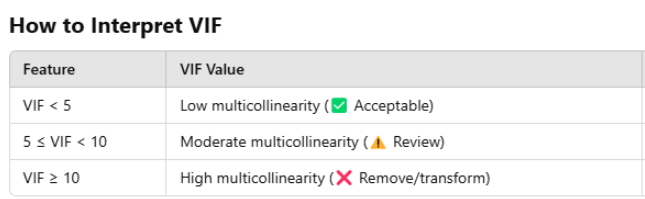

In [64]:
vif_df = pd.DataFrame()
vif_df["Features"] = X_train_lr_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_train_lr_vif.values, i) for i in range(X_train_lr_vif.shape[1])]
# Sort in ascending VIF order
vif_df = vif_df.sort_values(by='VIF', ascending=True).reset_index(drop=True)
vif_df

,Features,VIF
0,color,1.121804
1,clarity,1.229721
2,cut,1.471358
3,table,1.596230
4,depth,3.187171
5,carat,48.228072
6,height,137.356877
7,width,203.461141
8,length,264.583012


The Correlation matrix above showed the strength and direction of relationships between pairs of features. For example, `carat` has strong positive correlations with `price` (0.92), `length` (0.98), `width` (0.95), and `height` (0.96).**High correlation coefficients indicate multicollinearity**.

The VIF values provide a measure of the degree of multicollinearity among the features. Where the VIF value is larger than 10 indicate significant multicollinearity, particularly among `length`, `width`, `height`, and `carat`.

<font color=indigo>💎**OBSERVATIONS**</font>

All the features except `clarity` have a VIF above 10 indicating multi-collinearity  which is prone to  inflate the variance of the coefficient estimates and make the model unstable, making it difficult to determine the individual effect of each feature on the dependent variable.

In [65]:
# Step 1: Create a composite feature 'Size'
X_train_lr_vif['volume'] = X_train_lr_vif['height'] * X_train_lr_vif['width'] * X_train_lr_vif['length']
X_test_lr_vif['volume'] = X_test_lr_vif['height'] * X_test_lr_vif['width'] * X_test_lr_vif['length']



# Step 2: Remove the original highly correlated features
X_train_lr_vif.drop(['height', 'width', 'length'], axis=1, inplace=True)
X_test_lr_vif.drop(['height', 'width', 'length'], axis=1, inplace=True)

# Recalculate VIF to confirm reduction in multicollinearity
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_lr_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_lr_vif.values, i) for i in range(X_train_lr_vif.shape[1])]

vif_data

,Feature,VIF
0,carat,3.897142
1,cut,1.463900
2,color,1.113993
3,clarity,1.208339
4,depth,1.307010
5,table,1.569264
6,volume,3.613665


The Condition Index looks at the overall structure of the predictors, while VIF focuses on individual predictors.

In [66]:
cov_matrix = np.cov(X_train_lr_vif.T)
eigenvals = np.linalg.eigvals(cov_matrix)
condition_index = np.sqrt(np.max(eigenvals) / eigenvals)
ci_df = pd.DataFrame({'Condition Index': condition_index}, index=X_train_lr_vif.columns)
ci_df

,Condition Index
carat,1.000000
cut,5.475116
color,4.272607
clarity,2.128521
depth,2.994028
table,2.343498
volume,2.620188


<font color=indigo>💎**OBSERVATIONS**</font>

**Carat as the Baseline**: The` carat `attribute, with an index value of 1.000000, serves as the reference point for comparing the influence of other attributes on the evaluation.

**Key Influencing Attributes**: `cut` (5.475116) and `color `(4.272607) exhibit significantly higher index values, suggesting they have a much greater impact on the analysis or valuation compared to `carat`.

**Moderate Influences**: Attributes like`clarity` (2.128521), `depth` (2.994028), `table` (2.343498), and `volume` (2.620188) also contribute, but to a lesser extent than `cut` and `color`.

**Relative Importance:** The condition indices reveal the ranked importance of these attributes, emphasizing that `cut` and `color `are pivotal factors in determining the diamond's overall quality or pricing.



In [67]:
# Build a Linear regression model with selected features
lr_vif_model = LinearRegression()
lr_vif_model.fit(X_train_lr_vif, y_train_lr_vif)

evaluate_model('Linear Regression + VIF selected Features', lr_vif_model, X_train_lr_vif, X_test_lr_vif, y_train_lr_vif, y_test_lr_vif)
model_comparison_df

,Model,RMSE(Training Set),RMSE(Test Set),R_squared Score,RMSE as pct of Mean Price
0,Baseline Model: Linear Regression,1082.41,1003.27,0.94,25.47
1,Linear Regression + VIF selected Features,1395.36,1402.45,0.88,35.60


In [68]:
# Get the coefficients and reshape to ensure they are 1-dimensional
lr_vif_coefficients = lr_vif_model.coef_.ravel()

# Create a DataFrame to display the feature importance
feature_importance_lr_vif = pd.DataFrame({
    'Feature': X_train_lr_vif.columns,
    'Coefficient': lr_vif_coefficients
})

# Sort the features by the absolute value of the coefficients
feature_importance_lr_vif['Absolute Coefficient'] = feature_importance_lr_vif['Coefficient'].abs()
feature_importance_lr_vif = feature_importance_lr_vif.sort_values(by='Absolute Coefficient', ascending=False)

print(feature_importance_lr_vif)

   Feature  Coefficient  Absolute Coefficient
0    carat     1.219778              1.219778
3  clarity     0.175250              0.175250
2    color    -0.145303              0.145303
6   volume    -0.069052              0.069052
1      cut     0.034677              0.034677
4    depth    -0.009099              0.009099
5    table    -0.006018              0.006018


### 8.1.2_Linear Regression with Regularization

`When dealing with multicollinearity in your dataset, you can use regularization techniques to mitigate its effects without having to perform feature selection. Regularization techniques such as Ridge Regression (L2 regularization) and Lasso Regression (L1 regularization) can help stabilize your linear regression model by adding a penalty term to the loss function. This penalty term discourages overly complex models by shrinking the regression coefficients.`

#### Lasso Regression (L1)


* Use when you want to perform feature selection along with regularization.

* Ideal for cases where you suspect some features are not contributing much to the model.

* Can result in simpler, more interpretable models by shrinking some coefficients exactly to zero.

In [69]:
from sklearn.linear_model import Lasso, LassoCV

# Perform cross-validation to tune the alpha parameter
lasso_cv = LassoCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5, random_state=42)
lasso_cv.fit(X_train_lr, y_train_lr)

# Get the best alpha value
optimal_alpha = lasso_cv.alpha_
print(f'Optimal alpha: {optimal_alpha}')

# Build a Lasso regression model with the optimal alpha (if needed
lasso_model = Lasso(alpha=optimal_alpha)
lasso_model.fit(X_train_lr, y_train_lr)

evaluate_model('Lasso Regression', lasso_model, X_train_lr, X_test_lr, y_train_lr, y_test_lr)

# Get the coefficients and reshape to ensure they are 1-dimensional
lasso_coefficients = lasso_model.coef_.ravel()

# Create a DataFrame to display the feature importance
feature_importance_lasso = pd.DataFrame({
    'Feature': X_train_lr.columns,
    'Coefficient': lasso_coefficients
})

# Sort the features by the absolute value of the coefficients
feature_importance_lasso['Absolute Coefficient'] = feature_importance_lasso['Coefficient'].abs()
feature_importance_lasso = feature_importance_lasso.sort_values(by='Absolute Coefficient', ascending=False)

print(feature_importance_lasso)

Optimal alpha: 0.01
   Feature  Coefficient  Absolute Coefficient
6   length     0.813561              0.813561
8   height     0.184889              0.184889
3  clarity     0.180548              0.180548
2    color    -0.117222              0.117222
7    width     0.075145              0.075145
4    depth     0.014548              0.014548
1      cut     0.012079              0.012079
0    carat     0.000000              0.000000
5    table    -0.000000              0.000000


In [70]:
model_comparison_df

,Model,RMSE(Training Set),RMSE(Test Set),R_squared Score,RMSE as pct of Mean Price
0,Baseline Model: Linear Regression,1082.41,1003.27,0.94,25.47
1,Linear Regression + VIF selected Features,1395.36,1402.45,0.88,35.60
2,Lasso Regression,1115.45,1045.59,0.93,26.54


#### Ridge Regression (L2)


* Ridge Regression is ideal when you want to perform regularization to prevent overfitting but do not necessarily want to perform feature selection. It keeps all features in the model by shrinking their coefficients towards zero.

* <font color=firebrick>Ideal for Multicollinearity</font>: Ridge Regression is particularly useful when you have multicollinearity in your dataset. It helps stabilize the model by reducing the impact of correlated features.

* Keeps All Features: Unlike Lasso Regression, Ridge Regression does not shrink coefficients to exactly zero. Instead, it shrinks all coefficients towards zero, ensuring that all features are retained in the model.

In [71]:
from sklearn.linear_model import Ridge, RidgeCV

# Perform cross-validation to tune the alpha parameter
ridge_cv = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], cv=5)
ridge_cv.fit(X_train_lr, y_train_lr)


# Get the best alpha value
optimal_alpha = ridge_cv.alpha_
print(f'Optimal alpha: {optimal_alpha}')

# Build a Ridge regression model with the optimal alpha (if needed
ridge_model = Ridge(alpha=optimal_alpha)
ridge_model.fit(X_train_lr, y_train_lr)


evaluate_model('Ridge Regression', ridge_model, X_train_lr, X_test_lr, y_train_lr, y_test_lr)


# Get the coefficients and reshape to ensure they are 1-dimensional
ridge_coefficients = ridge_model.coef_.ravel()

# Create a DataFrame to display the feature importance
feature_importance_ridge = pd.DataFrame({
    'Feature': X_train_lr.columns,
    'Coefficient': ridge_coefficients
})

# Sort the features by the absolute value of the coefficients
feature_importance_ridge['Absolute Coefficient'] = feature_importance_ridge['Coefficient'].abs()
feature_importance_ridge = feature_importance_ridge.sort_values(by='Absolute Coefficient', ascending=False)

print(feature_importance_ridge)

Optimal alpha: 0.001
   Feature  Coefficient  Absolute Coefficient
6   length     0.939018              0.939018
3  clarity     0.199052              0.199052
7    width     0.139619              0.139619
2    color    -0.133017              0.133017
8   height     0.056817              0.056817
4    depth     0.051555              0.051555
0    carat    -0.041517              0.041517
1      cut     0.029943              0.029943
5    table     0.012253              0.012253


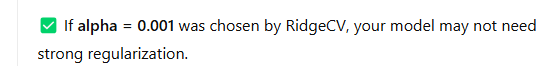

* When alpha is very small, Ridge behaves like Ordinary Least Squares (OLS); (minimal regularization).
This means regularization wasn’t needed much, possibly because:
* Multicollinearity wasn’t hurting predictions.
* The dataset was large enough for OLS-like behavior to work well.
* Higher alpha values caused underfitting.


In [72]:
model_comparison_df

,Model,RMSE(Training Set),RMSE(Test Set),R_squared Score,RMSE as pct of Mean Price
0,Baseline Model: Linear Regression,1082.41,1003.27,0.94,25.47
1,Linear Regression + VIF selected Features,1395.36,1402.45,0.88,35.60
2,Lasso Regression,1115.45,1045.59,0.93,26.54
3,Ridge Regression,1082.41,1003.27,0.94,25.47


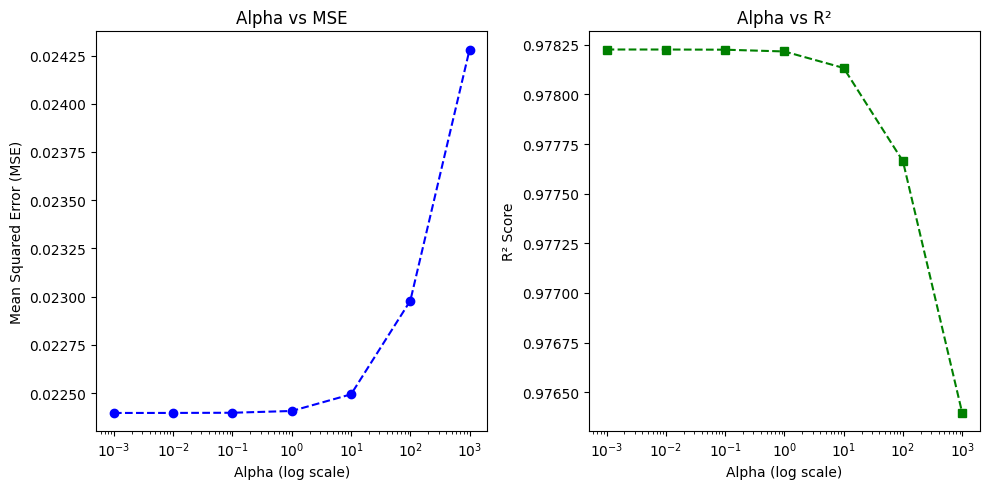

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Define a range of alpha values to test
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Store performance metrics
mse_scores = []
r2_scores = []

# Perform cross-validation for each alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    mse = -np.mean(cross_val_score(ridge, X_train_lr, y_train_lr, scoring='neg_mean_squared_error', cv=5))
    r2 = np.mean(cross_val_score(ridge, X_train_lr, y_train_lr, scoring='r2', cv=5))

    mse_scores.append(mse)
    r2_scores.append(r2)

# Plot MSE vs Alpha
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(alphas, mse_scores, marker='o', linestyle='--', color='b')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Alpha vs MSE')

# Plot R² vs Alpha
plt.subplot(1, 2, 2)
plt.plot(alphas, r2_scores, marker='s', linestyle='--', color='g')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('R² Score')
plt.title('Alpha vs R²')

plt.tight_layout()
plt.show()


#### Elastic Net Regression

* Combines L1 and L2 Regularization: Elastic Net is a hybrid approach that combines both L1 (Lasso) and L2 (Ridge) regularization techniques. This allows for both feature selection and coefficient shrinkage.

* <font color=red>Ideal for High-Dimensional Data</font>: Elastic Net is particularly useful when you have high-dimensional data with many features, some of which may be correlated and some irrelevant. It helps balance the trade-off between Ridge and Lasso.

* Adjustable Mixing Parameter: The l1_ratio parameter controls the balance between L1 and L2 regularization. A value of 0 corresponds to Ridge regression, a value of 1 corresponds to Lasso regression, and intermediate values balance the two.

In [74]:
from sklearn.linear_model import ElasticNet, ElasticNetCV


# Perform cross-validation to tune the alpha and l1_ratio parameters
elasticnet_cv = ElasticNetCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], l1_ratio=[0.1, 0.5, 0.7, 1.0], cv=5, random_state=42)
elasticnet_cv.fit(X_train_lr, y_train_lr)

# Get the best alpha and l1_ratio values
optimal_alpha = elasticnet_cv.alpha_
optimal_l1_ratio = elasticnet_cv.l1_ratio_
print(f'Optimal alpha: {optimal_alpha}')
print(f'Optimal l1_ratio: {optimal_l1_ratio}')

Optimal alpha: 0.01
Optimal l1_ratio: 0.1


With an optimal `l1_ratio of 0.1`, it means that the regularization is primarily dominated by L2 regularization, with a smaller component of L1 regularization.(90% L2 regularization and 10% L1 regularization)

In [75]:
# Build an ElasticNet regression model with the optimal alpha and l1_ratio
elasticnet_model = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio)
elasticnet_model.fit(X_train_lr, y_train_lr)

evaluate_model('Elastic Net Regression', elasticnet_model, X_train_lr, X_test_lr, y_train_lr, y_test_lr)

# Get the coefficients and reshape to ensure they are 1-dimensional
elasticnet_coefficients = ridge_model.coef_.ravel()

# Create a DataFrame to display the feature importance
feature_importance_elasticnet = pd.DataFrame({
    'Feature': X_train_lr.columns,
    'Coefficient': elasticnet_coefficients
})

# Sort the features by the absolute value of the coefficients
feature_importance_elasticnet['Absolute Coefficient'] = feature_importance_elasticnet['Coefficient'].abs()
feature_importance_elasticnet = feature_importance_elasticnet.sort_values(by='Absolute Coefficient', ascending=False)

print(feature_importance_elasticnet)

   Feature  Coefficient  Absolute Coefficient
6   length     0.939018              0.939018
3  clarity     0.199052              0.199052
7    width     0.139619              0.139619
2    color    -0.133017              0.133017
8   height     0.056817              0.056817
4    depth     0.051555              0.051555
0    carat    -0.041517              0.041517
1      cut     0.029943              0.029943
5    table     0.012253              0.012253


In [76]:
model_comparison_df

,Model,RMSE(Training Set),RMSE(Test Set),R_squared Score,RMSE as pct of Mean Price
0,Baseline Model: Linear Regression,1082.41,1003.27,0.94,25.47
1,Linear Regression + VIF selected Features,1395.36,1402.45,0.88,35.60
2,Lasso Regression,1115.45,1045.59,0.93,26.54
3,Ridge Regression,1082.41,1003.27,0.94,25.47
4,Elastic Net Regression,4184.99,1304.70,0.89,33.12


<font color=indigo>💎**OBSERVATIONS**</font>

1. **Baseline Model: Linear Regression**: This is a strong baseline. The model explains 94% of the variance in diamond prices and has a relatively low error rate (around 25% of the mean price). The fact that the test RMSE is slightly lower than the training RMSE suggests <font color='green'>good generalization</font>.

2. **Linear Regression + VIF Selected Features**:This model shows <font color=firebrick>significant overfitting</font>. The high training RMSE and lower test RMSE indicate that the model is memorizing the training data rather than learning generalizable patterns. The feature selection using VIF appears to have negatively impacted the model's performance.

3. **Lasso Regression**:Performs almost as well as the baseline linear regression, with slightly higher error rates. This suggests that some features might be less relevant and that Lasso's feature selection (by shrinking coefficients to zero) is <font color='green'>helping to avoid overfitting</font>.

4. **Ridge Regression**: Matches the performance of the baseline linear regression almost exactly. This shows that even without explicit feature selection (like Lasso), Ridge's regularization is <font color='green'>effective in controlling model complexity and preventing overfitting.</font>

5. **Elastic Net Regression**: <font color=firebrick>Exhibits overfitting</font>, although not as severe as the VIF-selected linear regression. The performance is worse than both Lasso and Ridge individually, suggesting that the balance between L1 and L2 might need further tuning.

## 8.2_Advanced Model Considerations

`Random Forest , Gradient Boosting Regressors or XGBoost can capture interactions better than linear regression.`

### 8.2.1_Random Forest Regressor

Random Forest is an ensemble learning method that constructs multiple decision trees and combines their results. It handles non-linear relationships and interactions between features well.

In [77]:
from sklearn.ensemble import RandomForestRegressor

X_train_rf = X_train_p1.copy()
y_train_rf = y_train_log.copy()

X_test_rf = X_test_p1.copy()
y_test_rf= y_test_log.copy()

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

evaluate_model('Random Forest Regressor', rf_model, X_train_rf, X_test_rf, y_train_rf, y_test_rf)
#model_comparison_df

### 8.2.2_Gradient Boosting Regressor



In [78]:
from sklearn.ensemble import GradientBoostingRegressor

X_train_gbr = X_train_p1.copy()
y_train_gbr = y_train_log.copy()

X_test_gbr = X_test_p1.copy()
y_test_gbr= y_test_log.copy()

gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr_model.fit(X_train_gbr, y_train_gbr)

evaluate_model('Gradient Boosting Regressor', gbr_model, X_train_gbr, X_test_gbr, y_train_gbr, y_test_gbr)
#model_comparison_df

### 8.2.3_XGBoost Regressor

`XGBoost (Extreme Gradient Boosting) is a powerful implementation of gradient boosting that is known for its performance and efficiency. It includes regularization to prevent overfitting and supports parallel processing.`



XGBoost is a sophisticated boosting algorithm that handles multicollinearity more effectively than simpler models by naturally performing feature selection during training, assigning less weight to correlated and less important features. XGBoost includes L1 (reg_alpha) and L2 (reg_lambda) regularization terms, which help in managing multicollinearity by penalizing large coefficients. This can reduce the effect of correlated features and improve overall model performance.






In [79]:
import xgboost as xgb

X_train_xgb = X_train_p1.copy()
y_train_xgb = y_train_log.copy()

X_test_xgb = X_test_p1.copy()
y_test_xgb= y_test_log.copy()

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

evaluate_model('XGBoost (Extreme Gradient Boosting) Regressor', xgb_model, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb)
model_comparison_df

,Model,RMSE(Training Set),RMSE(Test Set),R_squared Score,RMSE as pct of Mean Price
0,Baseline Model: Linear Regression,1082.41,1003.27,0.94,25.47
1,Linear Regression + VIF selected Features,1395.36,1402.45,0.88,35.60
2,Lasso Regression,1115.45,1045.59,0.93,26.54
3,Ridge Regression,1082.41,1003.27,0.94,25.47
4,Elastic Net Regression,4184.99,1304.70,0.89,33.12
5,Random Forest Regressor,205.32,556.75,0.98,14.13
6,Gradient Boosting Regressor,597.25,607.07,0.98,15.41
7,XGBoost (Extreme Gradient Boosting) Regressor,495.85,545.01,0.98,13.83


<font color=indigo>💎**OBSERVATIONS**</font>

* The Random Forest model shows a relatively large difference in RMSE between the training and test sets, suggesting it may be overfitting.
* The Gradient Boosting model shows a smaller difference in RMSE between the training and test sets compared to the Random Forest model, indicating it is less prone to overfitting.
* The XGBoost model has the smallest difference in RMSE between the training and test sets, suggesting it is the least likely to be overfitting among the three models.

These results indicate that the XGBoost model has the lowest RMSE on the test set and the lowest RMSE as a percentage of mean price, while maintaining a high R2 score. This suggests that it has the best performance in terms of prediction accuracy and generalization to new data.

Therefore, you should move forward with the XGBoost model to the model optimization phase by implementing hyperparameter tuning. Hyperparameter optimization techniques like Grid Search, Random Search, or Bayesian Optimization can help you find the best parameters to further improve the model's performance.

# 9_Feature Selection

## 9.1_Feature Importance

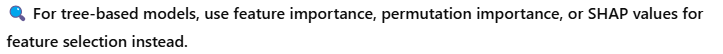

In [80]:
# Interpretation RMSE as percentage of mean and median
def rmse_interpretation(rmse, mean_price):
  # Compute RMSE as a percentage of mean and median price
  rmse_mean_pct = (rmse / mean_price) * 100
  print(f"RMSE as percentage of mean price: {rmse_mean_pct:.2f}%")
  if rmse_mean_pct > 10:
      print("⚠️ RMSE is high relative to the mean price. Outliers may be affecting the model.")
  else:
      print("✅ RMSE is within a reasonable range.")

In [81]:
X_train_2 = X_train_p1.copy()
y_train_2 = y_train_log.copy()

X_test_2 = X_test_p1.copy()
y_test_2 = y_test_log.copy()

XGBoost is a powerful  advanced ensemble technique that provides feature importance scores. By selecting features based on these scores, we can focus on the most relevant features and potentially to improve the accuracy and robustness of our predictions.

`We can leverage XGBoost's ability to rank feature importance to select the most relevant variables for predicting diamond price.`

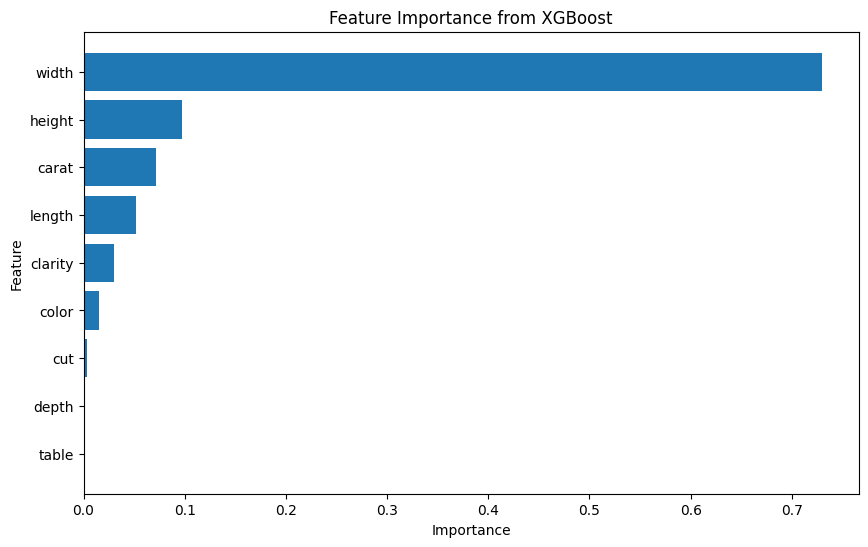

,Feature,Importance
7,width,0.729464
8,height,0.097798
0,carat,0.071577
6,length,0.051616
3,clarity,0.030002
2,color,0.015275
1,cut,0.003189
4,depth,0.000645
5,table,0.000434


In [82]:
# Train the XGBoost model
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train_2, y_train_2)

# Get feature importance scores
feature_importances = xgb.feature_importances_
feature_names = X_train_2.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()

importance_df

<font color=indigo>💎**OBSERVATIONS**</font>

Features with higher importance scores play a more critical role in predicting the target variable, while those with lower scores have less impact.

1.**Size-Related Features are Crucial**: The physical dimensions of the diamond (width, height, length) are the most significant features, with width being the most important. This suggests that the overall size of the diamond heavily influences its price.

2.**Carat Weight Matters, but Not the Most**: While carat weight is traditionally considered a major factor in a diamond's value, its importance is moderate in this model, indicating that other size dimensions play a more crucial role.

3.**Clarity, Color, and Cut**: These features, which are usually important in assessing diamond quality, have lower importance scores. This might suggest that the market values the physical dimensions more than these quality factors.

4.**Depth and Table**: Features related to cut quality have very low importance scores. This might be due to multicollinearity or other factors overshadowing their impact.

SelectFromModel is a feature selection method in machine learning that leverages a model's feature importance to select the most relevant features for your dataset. By using a trained model, like XGBoost or any other estimator with an importance attribute, SelectFromModel evaluates the importance of each feature and retains only those whose importance exceeds a specified threshold. This process helps reduce the dimensionality of the dataset, removing less informative features and potentially improving the model's performance and generalization. It's a powerful tool for enhancing model efficiency and interpretability by focusing on the most impactful features.

In [83]:
# Select Top 5 Features with highest importance score

print(f'XGB Regressor + Top 6 Features w.r.t Importance score')
print('------------------------------------------------------')
selected_features = importance_df['Feature'].head(6).tolist()
print(f'Selected Features: {selected_features}')

X_train_selected = X_train_2[selected_features]
X_test_selected = X_test_2[selected_features]
y_train_selected = y_train_2.copy()
y_test_selected = y_test_2.copy()

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train_selected, y_train_selected)

evaluate_model('XGBoost Regressor + Top 6 Features', xgb_model, X_train_selected, X_test_selected, y_train_selected, y_test_selected)
model_comparison_df

XGB Regressor + Top 6 Features w.r.t Importance score
------------------------------------------------------
Selected Features: ['width', 'height', 'carat', 'length', 'clarity', 'color']


,Model,RMSE(Training Set),RMSE(Test Set),R_squared Score,RMSE as pct of Mean Price
0,Baseline Model: Linear Regression,1082.41,1003.27,0.94,25.47
1,Linear Regression + VIF selected Features,1395.36,1402.45,0.88,35.60
2,Lasso Regression,1115.45,1045.59,0.93,26.54
3,Ridge Regression,1082.41,1003.27,0.94,25.47
4,Elastic Net Regression,4184.99,1304.70,0.89,33.12
5,Random Forest Regressor,205.32,556.75,0.98,14.13
6,Gradient Boosting Regressor,597.25,607.07,0.98,15.41
7,XGBoost (Extreme Gradient Boosting) Regressor,495.85,545.01,0.98,13.83
8,XGBoost Regressor + Top 6 Features,483.02,556.05,0.98,14.11


# 10_Model Optimization

## 10.1_Hyperparameter Tuning: Bayesian Optimization


In [84]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.5 MB/s eta 0:00:00


In [85]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [86]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = XGBRegressor(**param, random_state=42)

    model.fit(X_train_2, y_train_2)
   # Evaluate the model
    y_pred_log = model.predict(X_test_2)
    # Xxponentiate predictions back to original scale
    y_pred = np.expm1(y_pred_log)

    # Calculate Metrics
    mse= mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    return rmse

study = optuna.create_study(direction='minimize',sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=100)

[I 2025-04-27 13:25:31,369] A new study created in memory with name: no-name-219070d8-07f0-445c-a61c-1e5f129a5891
[I 2025-04-27 13:25:38,485] Trial 0 finished with value: 577.1214397767596 and parameters: {'n_estimators': 437, 'max_depth': 10, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 0.8661761457749352}. Best is trial 0 with value: 577.1214397767596.
[I 2025-04-27 13:25:43,795] Trial 1 finished with value: 525.9589753488384 and parameters: {'n_estimators': 641, 'max_depth': 8, 'learning_rate': 0.01596950334578271, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'min_child_weight': 3, 'reg_alpha': 0.18182496720710062, 'reg_lambda': 0.18340450985343382}. Best is trial 1 with value: 525.9589753488384.
[I 2025-04-27 13:25:45,711] Trial 2 finished with value: 536.2051846075343 and parameters: {'n_estimators': 374, 'max_depth': 

In [87]:
# Best parameters
print("Best RMSE:", study.best_value)
print("Best parameters:", study.best_trial.params)

Best RMSE: 523.287504628192
Best parameters: {'n_estimators': 561, 'max_depth': 7, 'learning_rate': 0.041079883288535055, 'subsample': 0.7789649467293819, 'colsample_bytree': 0.8130469065820093, 'min_child_weight': 3, 'reg_alpha': 0.26924323094938096, 'reg_lambda': 0.37728416310462265}


In [88]:
model = XGBRegressor(**study.best_trial.params,random_state=42,n_jobs=-1)

model.fit(X_train_2, y_train_2)
# Evaluate the model
y_pred_log = model.predict(X_test_2)
y_pred = np.expm1(y_pred_log)

# Calculate Metrics
mse= mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('XBGRegressor + Hyperparameter tuning')
print('------------------------------------')

print(f'RMSE: {rmse:.2f}')
print(f'R2 Score: {r2:.2f}')

mean_price  = y_test.mean()
rmse_interpretation(rmse, mean_price)

XBGRegressor + Hyperparameter tuning
------------------------------------
RMSE: 523.29
R2 Score: 0.98
RMSE as percentage of mean price: 13.28%
⚠️ RMSE is high relative to the mean price. Outliers may be affecting the model.


<font color=indigo>💎**OBSERVATIONS**</font>

The model demonstrates strong performance with an R² value of 0.98 and an RMSE as a percentage of the mean at 13.28%. However, the RMSE as a percentage of the median (21.35%) indicates a tendency to overestimate the prices of high-value diamonds. This suggests that a few very expensive diamonds could be inflating the RMSE, despite the model performing well for the majority of diamonds.

**The hyperparameters found by Optuna likely optimized the model's performance, allowing it to better manage the relationship between features, even when multicollinear features are present.**

In [89]:
from sklearn.metrics import median_absolute_error

# Calculate Median Absolute Error
medae = median_absolute_error(y_test, y_pred)

print(f"Median Absolute Error (MedAE): {medae:.2f}")

Median Absolute Error (MedAE): 92.26


<font color=indigo>💎**OBSERVATIONS**</font>

The model generally predicts diamond prices within 92.26 dollars of the actual prices for half of the diamonds, but there are some larger errors (predictions deviate significantly from actual prices)the  that push the RMSE up to 523.29 dollars. This suggests that while the model performs reasonably well for many diamonds, there are some instances where the predictions are quite far off.

✅ Most predictions are very close to the actual price (low MedAE).

⚠️ Some high-priced diamonds still have large errors (higher RMSE).

🔎 Next steps: Residual analysis to check if errors still increase for expensive diamonds.

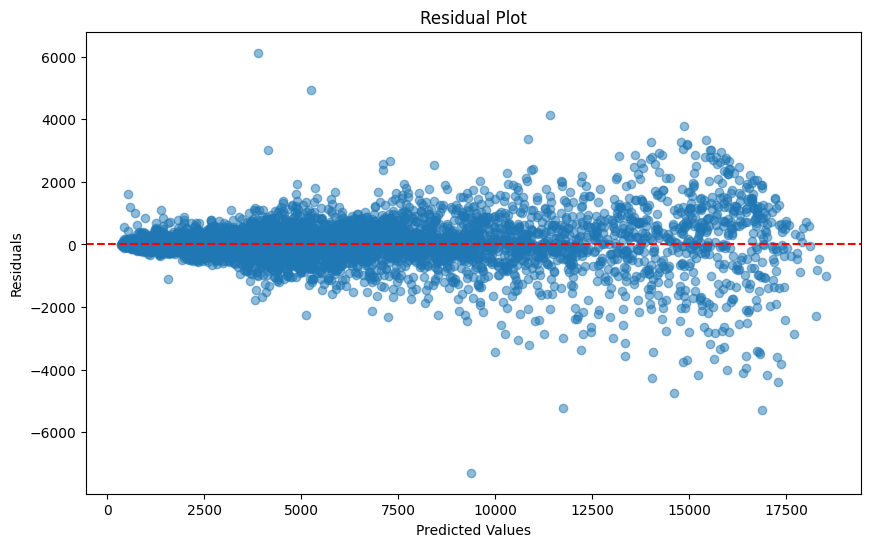

In [90]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.title('Residual Plot')
plt.show()

<font color=indigo>💎**OBSERVATIONS**</font>

**Centering Around Zero**:The residuals (blue dots) are centered around the red dashed horizontal line at zero. This indicates that the model's predictions are, on average, unbiased.

**Spread of Residuals** :The spread of residuals is relatively constant across the range of predicted values, although it slightly increases at higher predicted values. This suggests that while the model's error variance is mostly stable, there may be some heteroscedasticity (increasing variance) at higher predicted values.

**Outliers** :There are a few residuals significantly higher or lower than the rest, indicating potential outliers or points where the model's predictions are less accurate.

**Pattern**:There doesn't appear to be a clear pattern in the residuals, which is a good sign. It suggests that the model has captured the underlying relationship between the variables well.


**Overall Interpretation**

The residual plot indicates that the regression model is performing reasonably well, with unbiased predictions and relatively constant error variance. However, there may be some issues with heteroscedasticity and outliers.

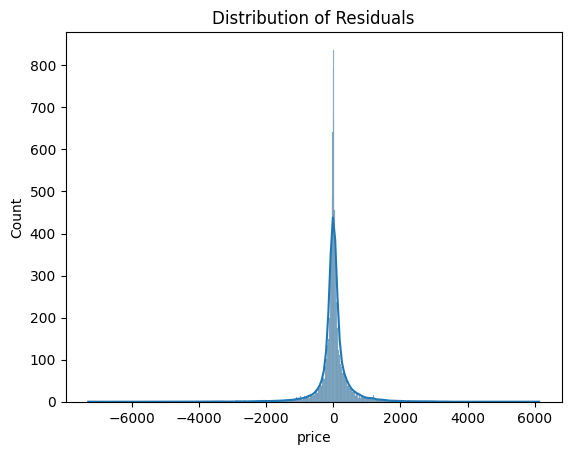

In [91]:
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

<u>Distribution Characteristics</u>

**Highly Peaked Around Zero**: The histogram shows a high peak around zero, indicating that most of the residuals are close to zero. This suggests that the model's predictions are generally accurate and close to the actual values.

**Few Extreme Residuals**: There are very few residuals at the extreme ends (both negative and positive). This means that the model rarely makes large prediction errors.

<u>Implication</u>

Accuracy of the Model: The concentration of residuals around zero indicates that the model is performing well, with most of its predictions being close to the actual prices.

**Outliers and Variability**: The few extreme residuals suggest the presence of outliers or instances where the model's predictions deviate significantly from the actual values.

Overall, the residual plot indicates that the regression model used to predict the prices is quite accurate, with the majority of the predictions being close to the actual values.

# 11. Conclusion


In conclusion, the analysis revealed that all three main factors—cut, color, and clarity—have significant impacts on diamond prices. However, size-related features, particularly the physical dimensions of the diamond (width, height, and length), play the most critical role in predicting price. By employing advanced techniques such as Bayesian optimization and feature selection methods, we have developed a predictive model with strong performance metrics: an R² score of 0.98 and an RMSE of 523.29. This model, while highly accurate, still shows a tendency to overestimate the prices of high-value diamonds. Future improvements could involve further outlier treatment and exploring ensemble methods to enhance the model's accuracy and reliability. Ultimately, the insights gained from this study provide valuable guidance for jewelers in pricing diamonds more effectively.



Take note:

**Heteroscedasticity**: There's a noticeable increase in the spread of residuals as the predicted values increase. This indicates potential heteroscedasticity (non-constant variance of residuals). You might want to look into methods to address this, such as transforming your dependent variable or using weighted least squares regression.